In [13]:
import numpy as np
import pandas as pd
import os, glob
from sqlalchemy import create_engine
import sqlite3
from sqlite3 import Error
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm, metrics
#from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import math
import gzip
import csv
import matplotlib.pyplot as plt
import psycopg2

In [3]:
# path with all normalized data -chartevents, lab events, procedure events
path = "C:/Users/mnigc/Documents/PCM/"

# FOR CHARTEVENTS
# loading all files from path with chartevent name
cohort_files = glob.glob(os.path.join(path, "*.csv"))

# initializing data frame
cohort_df = []
# loading all files into data frame
for f in cohort_files:
    df = pd.read_csv(f)
    df['file'] = f.split('/')[-1]
    cohort_df.append(df)
    
# concatenating files into single data frame    
cohort = pd.concat(cohort_df, ignore_index=True)

In [9]:
#  getting subject ids from cohort files
patient_ids = cohort['subject_id']

# get unique patient ids
unique_ids=np.unique(patient_ids)

# clear NaN
unique_ids=unique_ids[~np.isnan(unique_ids)]

len(unique_ids)

2596

# Unzipping mimic files

In [ ]:
# unzipping .gz version of admissions
admissions_unzip = gzip.open('ADMISSIONS.csv.gz', 'r')

# admissions file
admissions = pd.read_csv(admissions_unzip)

admissions=admissions[admissions['SUBJECT_ID'].isin(unique_ids)]

#print(admissions)

In [ ]:
# unzipping .gz version of patients
patients_unzip = gzip.open('PATIENTS.csv.gz','r')

# patients file
patients = pd.read_csv(patients_unzip)

patients=patients[patients['SUBJECT_ID'].isin(unique_ids)]

# Demographics/static-only feature extraction

In [ ]:
# Get ethnicities
ethnicities = admissions[['SUBJECT_ID','ETHNICITY']]
#ethnicities['ETHNICITY'].value_counts()

# one hot encoding
# NEED TO ASK ABOUT BUCKETING
ethnicities = pd.get_dummies(ethnicities, columns=['ETHNICITY']) 
# ethnicities for patient subset
ethnicities[ethnicities['SUBJECT_ID'].isin(unique_ids)]


In [26]:
# Get marital status
marital_status=admissions[['SUBJECT_ID','MARITAL_STATUS']]
# One hot encoding
marital_status = pd.get_dummies(marital_status, columns=['MARITAL_STATUS']) 
# Marital status for patient subset
marital_status[marital_status['SUBJECT_ID'].isin(uniquet_ids)]


,SUBJECT_ID,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED
5,26,0,0,0,0,1,0,0
10,32,0,0,0,0,0,0,0
15,36,0,0,1,0,0,0,0
16,36,0,0,1,0,0,0,0
17,36,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
15260,9375,0,0,1,0,0,0,0
15262,9377,0,0,1,0,0,0,0
15263,9377,0,0,1,0,0,0,0
15264,9377,0,0,1,0,0,0,0


In [27]:
# Get admission type
admit_type=admissions[['SUBJECT_ID','ADMISSION_TYPE']]
# One hot encoding
admit_type = pd.get_dummies(admit_type, columns=['ADMISSION_TYPE']) 
# Admit type for patient subset
admit_type[admit_type['SUBJECT_ID'].isin(unique_ids)]

,SUBJECT_ID,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT
5,26,0,1,0,0
10,32,1,0,0,0
15,36,0,1,0,0
16,36,0,1,0,0
17,36,1,0,0,0
...,...,...,...,...,...
15260,9375,0,1,0,0
15262,9377,0,1,0,0
15263,9377,0,1,0,0
15264,9377,0,1,0,0


In [28]:
# Get admission location
admit_loc=admissions[['SUBJECT_ID','ADMISSION_LOCATION']]
# One hot encoding
admit_loc = pd.get_dummies(admit_loc, columns=['ADMISSION_LOCATION']) 
# Admission location for patient subset
admit_loc[admit_loc['SUBJECT_ID'].isin(unique_patient_ids)]

,SUBJECT_ID,ADMISSION_LOCATION_** INFO NOT AVAILABLE **,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_HMO REFERRAL/SICK,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY
5,26,0,0,0,0,0,1,0,0,0
10,32,0,0,0,0,1,0,0,0,0
15,36,0,1,0,0,0,0,0,0,0
16,36,0,0,1,0,0,0,0,0,0
17,36,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
15260,9375,0,0,1,0,0,0,0,0,0
15262,9377,0,0,1,0,0,0,0,0,0
15263,9377,0,0,1,0,0,0,0,0,0
15264,9377,0,0,1,0,0,0,0,0,0


In [29]:
# Get gender
gender=patients[['SUBJECT_ID','GENDER']]
# One hot encoding
gender = pd.get_dummies(gender, columns=['GENDER']) 
# Gender for patient subset
gender[gender['SUBJECT_ID'].isin(unique_ids)]

,SUBJECT_ID,GENDER_F,GENDER_M
3,252,0,1
10,261,0,1
14,265,0,1
16,267,1,0
17,268,1,0
...,...,...,...
9842,9984,1,0
9844,9987,0,1
9848,9991,1,0
9850,9993,0,1


Text(0.5, 0, 'Age')

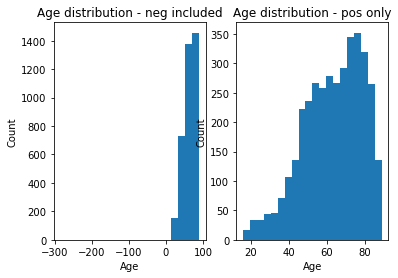

In [35]:
# Get date of birth and admission time to calculate age
dob=patients[['SUBJECT_ID','DOB']]
d_admit=admissions[['SUBJECT_ID','ADMITTIME']]

# parsing string to datetime
from datetime import datetime
dob=pd.to_datetime(dob['DOB'],format='%Y-%m-%d %H:%M:%S')
d_admit=pd.to_datetime(d_admit['ADMITTIME'],format='%Y-%m-%d %H:%M:%S')

dob=pd.DataFrame(dob)
dob['subject_id']=patients[['SUBJECT_ID']] # adding back subject id

d_admit=pd.DataFrame(d_admit)
d_admit['subject_id']=admissions[['SUBJECT_ID']] # adding back subject id

# merging dob and d_admit dataframes based on subject id
age_mat=dob.merge(d_admit,how='inner',on='subject_id')

# calculating age from admit time and date of birth
age=age_mat['ADMITTIME'].sub(age_mat['DOB'])
age=age / np.timedelta64(1, 'Y') # convert to years

age=pd.DataFrame(age) 
age['subject_id'] =age_mat[['subject_id']] # adding back subject id


check_neg=(age.loc[age[0]<0]) # check for negative age
print(check_neg)

pos_age=(age.loc[age[0]>0]) # only returning positive ages


plt.subplot(1,2,1)

# flattening all ages for plotting
flat_all=age[0].ravel()
# histogram of age distribution with plot labels
plt.hist(flat_all,bins=20)
plt.title("Age distribution - neg included")
plt.ylabel("Count")
plt.xlabel("Age")


plt.subplot(1,2,2)
# flattening positive age array for plotting
flat_pos=pos_age[0].ravel()
#print(flat_pos)
# histogram of age distribution with plot labels
plt.hist(flat_pos,bins=20)
plt.title("Age distribution - pos only")
plt.ylabel("Count")
plt.xlabel("Age")

In [ ]:
# Height

In [ ]:
# Weight

In [ ]:
# BMI